# **KNN**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import preprocessing as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Obtenemos los dataframes con los que trabajaremos

In [3]:
X, y = pp.get_X_y_from_dataset()

Hay un problema... la variable target "llovieron_hamburguesas_al_dia_siguiente" contiene NaNs (~2600). Esto es un problema a la hora de separar en train-valdev-holdout usando train_test_split si queremos preservar la proporción entre las clases del target en la partición (es decir, pasandole a esa función stratify=y). Como test-holdout nunca debe ver los datos de train o valdev, no deberíamos rellenar dichos NaNs usando datos de otras instancias (si no habría data leaks). Por ende, decidimos completar estos NaNs con la clase mayoritaria por lejos, el "no". 

In [4]:
y = pp.fill_nan_with_simple_imputer(y, ["llovieron_hamburguesas_al_dia_siguiente"], "most_frequent")

También no necesitamos la columna de id.

In [5]:
pp.drop_features(y, ['id']) 

## Separamos en train y test-holdout
Test-holdout lo usaremos como métrica del mejor de los 5 modelos, para tener una idea antes que salga a producción. Tomaremos un 10% para el holdout, y hacemos que sea stratificado, de forma que divida el train y holdout teniendo en cuenta la proporción de la variable target. Notar que usamos el mismo RANDOM_STATE para todos los train_test_splits de los modelos para poder reproducir las mismas condiciones, entrenando y evaluando sobre las mismas particiones.

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, random_state=pp.RANDOM_STATE, test_size=0.1, stratify=y
)

# Preprocesamiento y Feature Engineering

## Label-encodeamos la variable target
Usaremos LabelEncoder para crear un mapping de los valores yes/no de la variable target a valores numericos. Va a asignarle al "no" un 0, y al "si" un 1, debido al orden alfabético. 

In [7]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.values.ravel())
y_train = pd.DataFrame(y_train, columns = ['llovieron_hamburguesas_al_dia_siguiente'])

## Eliminamos valores erráticos
El feature presión_atmosférica_tarde tiene algunos valores erráticos. Los eliminamos y dejamos temporalmente como NaN, de forma de rellenarlos (o no) a posteriori.

In [8]:
err_values_presion_atm = ['10.167.769.999.999.900', '1.009.555']

pp.convert_values_to_nan(X_train, 'presion_atmosferica_tarde', err_values_presion_atm)

Lo mismo con la nubosidad_tarde y nubosidad_temprano:

In [9]:
err_values_nubosidad = [9.0]

pp.convert_values_to_nan(X_train, 'nubosidad_tarde', err_values_nubosidad)
pp.convert_values_to_nan(X_train, 'nubosidad_temprano', err_values_nubosidad)

## Dropeamos features que no nos interesan

In [10]:
pd.set_option("display.max_columns", None) # Esto es para mostrar todos los features al imprimir

In [11]:
pp.drop_features(X_train, [
    'id',
    'humedad_temprano',
    'temp_min',
    'rafaga_viento_max_direccion',
    'velocidad_viendo_tarde',
    'velocidad_viendo_temprano',
    'direccion_viento_temprano',
    'direccion_viento_tarde',
    'rafaga_viento_max_velocidad'
])

## Convertimos variables para que el modelo pueda usarlas
Comenzamos haciendo dummy encoding de las variables que sean categóricas, no ordinales y de baja cardinalidad. Pero antes, vamos a crear un feature a partir del dia: el mes. El año no porque con este modelo vamos a querer predecir por mucho tiempo en el futuro, y esos años futuros obviamente no aparecen en el dataset. Además año a año no cambia mucho la lluvia, pero sí hay meses que llueve más o menos. El día del mes tampoco importa mucho porque no hay una correlación del mismo con la lluvia de hamburguesas.

In [12]:
X_train["dia"] = pd.to_datetime(X_train["dia"], format = "%Y-%m-%d", errors = "coerce")

X_train["mes"] = X_train["dia"].dt.month
pp.drop_features(X_train, ["dia"])

Y ahora que tenemos todas las variables categóricas no ordinales listas, las one-hot-encodeamos.

In [13]:
X_train = pp.one_hot_encode(X_train, ["barrio"])
pp.drop_features(X_train, ["barrio_nan"])

Y encodeamos la variable binaria "llovieron_hamburguesas_hoy".

In [14]:
X_train["llovieron_hamburguesas_hoy"] = label_encoder.fit_transform(X_train["llovieron_hamburguesas_hoy"])

Esto a su vez resuelve los missings de estas variables categóricas, pues las trata como una categoría más.

## Estimamos missings con IterativeImputer
Dado que el dataset contiene muchos missings en variables relevantes para el target, como las horas de sol, decidimos llevar a cabo un método potente para completar missings. Usamos IterativeImputer de Sklearn, que es una implementación del algoritmo MICE.

In [15]:
X_train = pp.fill_with_iterative_imputer(X_train)

[IterativeImputer] Completing matrix with shape (104731, 61)
[IterativeImputer] Ending imputation round 1/4, elapsed time 23.37
[IterativeImputer] Change: 128.06649077613994, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 2/4, elapsed time 44.96
[IterativeImputer] Change: 49.939799831029376, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 3/4, elapsed time 66.04
[IterativeImputer] Change: 14.121337578009305, scaled tolerance: 1.041 
[IterativeImputer] Ending imputation round 4/4, elapsed time 87.44
[IterativeImputer] Change: 9.543807486441107, scaled tolerance: 1.041 


/home/laucha/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Completing matrix with shape (104731, 61)
[IterativeImputer] Ending imputation round 1/4, elapsed time 0.24
[IterativeImputer] Ending imputation round 2/4, elapsed time 0.49
[IterativeImputer] Ending imputation round 3/4, elapsed time 0.74
[IterativeImputer] Ending imputation round 4/4, elapsed time 0.99


## Escalamos las variables
Para KNN, es super importante escalar/normalizar los features, pues se basa puramente en las distancias entre puntos.

In [16]:
features_to_scale = list(X_train.columns)
X_train = pp.standard_scale(X_train, features_to_scale)

In [17]:
X_train.head()

,horas_de_sol,humedad_tarde,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,temp_max,temperatura_tarde,temperatura_temprano,mes,barrio_Almagro,barrio_Balvanera,barrio_Barracas,barrio_Belgrano,barrio_Boedo,barrio_Caballito,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Constitución,barrio_Flores,barrio_Floresta,barrio_La Boca,barrio_La Paternal,barrio_Liniers,barrio_Mataderos,barrio_Monserrat,barrio_Monte Castro,barrio_Nueva Pompeya,barrio_Núñez,barrio_Palermo,barrio_Palermo cheto,barrio_Parque Avellaneda,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Puerto Madero,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristóbal,barrio_San Nicolás,barrio_San Telmo,barrio_Versalles,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortúzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque,barrio_Vélez Sársfield
0,1.249619,-2.210404,-0.537961,1.289013,-0.315254,-0.607843,-0.510178,-0.236137,0.394260,1.546515,1.621629,1.389377,1.048131,-0.144841,-0.145869,-0.1458,-0.144841,-0.145766,-0.14539,-0.145424,-0.145561,-0.146005,-0.152687,-0.145527,-0.144979,-0.144152,-0.145766,-0.155093,-0.146584,-0.146141,-0.145458,-0.146278,-0.144875,-0.145766,9.486375,-0.14814,-0.146414,-0.105275,-0.145081,-0.144704,-0.146822,-0.15018,-0.146788,-0.145527,-0.147533,-0.148945,-0.144979,-0.146278,-0.146278,-0.145971,-0.144359,-0.150744,-0.144875,-0.144566,-0.150147,-0.145937,-0.144875,-0.152458,-0.104344,-0.145253,-0.145766
1,-0.843562,1.225449,-0.537961,-0.711425,-0.315254,1.011985,0.095942,-0.251091,-0.272381,1.038859,0.888330,1.712833,-0.702364,-0.144841,-0.145869,-0.1458,-0.144841,-0.145766,-0.14539,-0.145424,-0.145561,-0.146005,-0.152687,-0.145527,-0.144979,-0.144152,-0.145766,-0.155093,-0.146584,-0.146141,-0.145458,-0.146278,-0.144875,-0.145766,-0.105414,-0.14814,-0.146414,-0.105275,-0.145081,-0.144704,-0.146822,-0.15018,6.812565,-0.145527,-0.147533,-0.148945,-0.144979,-0.146278,-0.146278,-0.145971,-0.144359,-0.150744,-0.144875,-0.144566,-0.150147,-0.145937,-0.144875,-0.152458,-0.104344,-0.145253,-0.145766
2,0.240503,-1.242558,-0.537961,-0.330911,-0.315254,0.161615,-1.092570,0.526224,0.527592,-0.131573,-0.175672,-1.105850,0.172883,-0.144841,-0.145869,-0.1458,-0.144841,-0.145766,-0.14539,-0.145424,-0.145561,-0.146005,-0.152687,-0.145527,-0.144979,-0.144152,-0.145766,-0.155093,-0.146584,-0.146141,-0.145458,-0.146278,-0.144875,-0.145766,-0.105414,-0.14814,-0.146414,-0.105275,-0.145081,-0.144704,-0.146822,-0.15018,-0.146788,-0.145527,-0.147533,-0.148945,-0.144979,-0.146278,-0.146278,-0.145971,-0.144359,-0.150744,-0.144875,-0.144566,-0.150147,-0.145937,6.902479,-0.152458,-0.104344,-0.145253,-0.145766
3,-0.700922,0.789918,1.510139,0.212680,-0.084288,1.011985,0.888284,0.227257,-0.761249,-0.963566,-1.038376,-0.582161,1.339880,-0.144841,-0.145869,-0.1458,-0.144841,-0.145766,-0.14539,-0.145424,-0.145561,-0.146005,-0.152687,-0.145527,-0.144979,-0.144152,-0.145766,-0.155093,-0.146584,-0.146141,-0.145458,-0.146278,-0.144875,-0.145766,-0.105414,-0.14814,-0.146414,-0.105275,-0.145081,-0.144704,-0.146822,-0.15018,-0.146788,-0.145527,-0.147533,-0.148945,-0.144979,-0.146278,-0.146278,-0.145971,-0.144359,-0.150744,-0.144875,-0.144566,-0.150147,-0.145937,-0.144875,-0.152458,-0.104344,-0.145253,6.860306
4,0.896648,-1.145774,-0.537961,-0.330911,-0.315254,1.011985,-0.300228,0.870033,1.223863,0.220967,0.068761,-0.628369,1.339880,-0.144841,-0.145869,-0.1458,-0.144841,-0.145766,-0.14539,-0.145424,-0.145561,-0.146005,-0.152687,-0.145527,-0.144979,-0.144152,-0.145766,-0.155093,-0.146584,-0.146141,-0.145458,-0.146278,-0.144875,-0.145766,-0.105414,-0.14814,-0.146414,-0.105275,-0.145081,6.910676,-0.146822,-0.15018,-0.146788,-0.145527,-0.147533,-0.148945,-0.144979,-0.14627

## Separamos en train y val-dev antes de hacer GridSearch

Nos guardamos a parte los DataFrames con los ids para luego poder hacer el archivo de predicciones de los datos privados de Flint que nos piden al final. Pero el feature "id" en sí no lo usaremos, porque es único por cada instancia, con lo cual puede perjudicar al modelo enseñándole a memorizarse las instancias.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    test_size = 0.3, 
                                                    random_state = pp.RANDOM_STATE, 
                                                    stratify=y_train)

# Buscamos los mejores hiperparámetros

En este modelo usaremos RandomSearch con Cross Validation de 3 folds, para buscar el mejor número de vecinos y si conviene ponderar cada vecino por su distancia o no.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

Obviamente no lo vamos a correr de vuelta porque va a tardar mucho tiempo... Por eso la primera línea, para no correr ese bloque de código. Cuando lo corrimos, nos guardamos el mejor modelo en un .pickle, que cargamos luego.

In [20]:
%%script false --no-raise-error # Para no ejecutar este bloque

from sklearn.model_selection import RandomizedSearchCV

knn_clf = KNeighborsClassifier(n_jobs = 1)

params = {"n_neighbors": np.arange(3, 100), "weights": ["distance", "uniform"]}

rgscv = RandomizedSearchCV(
    knn_clf, params, n_iter=30, scoring='accuracy', n_jobs=1, cv=3, return_train_score=True, verbose=3
).fit(X_train, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

# Guardamos todos los resultados del gridsearch en un csv:
pd.DataFrame(rgscv.cv_results_).to_csv("gridsearch_results/random_search_KNN.csv", index=False)

# También nos guardamos el mejor predictor (el KNN construido con los mejores parámetros)
joblib.dump(rgscv.best_estimator_, open("gridsearch_results/best_models/best_model_KNN.pickle", "wb"))

# Cargamos el modelo ya con los mejores hiperparámetros y lo entrenamos
Ya corrimos el RandomSearch y nos guardamos el mejor clasificador que encontró. Carguémoslo y usemos ese.

Parece que el mejor modelo considera a los 25 vecinos más cercanos al predecir, y pondera la importancia de los vecinos de acuerdo a la distancia (euclidiana, pues es la default de KNN).

Ahora entrenaremos este modelo pero en el X_train completo, para luego evaluarlo en X_test.

In [21]:
knn_clf = joblib.load("gridsearch_results/best_models/best_model_KNN.pickle")

knn_clf.fit(X_train, y_train)

/home/laucha/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/laucha/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_jobs=1, n_neighbors=25, weights='distance')

# Evaluamos en val-dev y medimos la performance

In [22]:
knn_pred = knn_clf.predict(X_test)

Como métrica para el f1, recall, etc. usaremos el average "weighted", que pondera los dos f1_score (uno con el "no" como clase positiva, el otro con el "si" como clase positiva) según el soporte de cada clase.  

### F1, Precision, Recall, Accuracy

In [23]:
f1_score(y_test, knn_pred, average='weighted')

0.8294848694095828

In [24]:
precision_score(y_test, knn_pred, average='weighted')

0.833699654298061

In [25]:
recall_score(y_test, knn_pred, average='weighted')

0.8443348185868873

In [26]:
accuracy_score(y_test, knn_pred)

0.8443348185868873

### Matriz de confusión

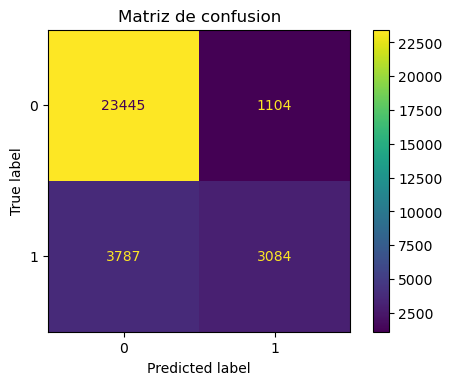

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, knn_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(dpi=100)
plt.title("Matriz de confusion")
disp.plot(ax=ax)

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(12, 8))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})'
    )
    #plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    


### AUC-ROC

In [29]:
knn_pred_proba = knn_clf.predict_proba(X_test)
knn_pred_proba_pos = knn_pred_proba[:,1] # nos quedamos con las probas de la clase positiva (1, o sea, "si")

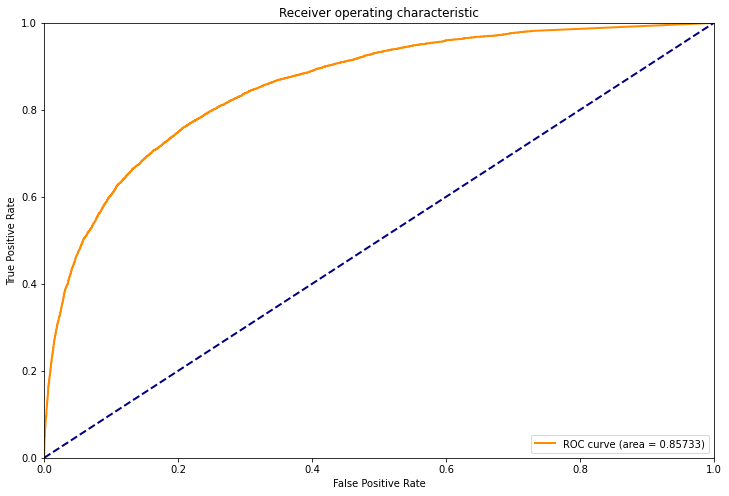

AUC_ROC:  0.8573325193713334


In [30]:
fpr, tpr, thresholds = roc_curve(y_test, knn_pred_proba_pos)
plot_roc(fpr, tpr, thresholds)
print("AUC_ROC: ", roc_auc_score(y_test, knn_pred_proba_pos))

# Predicción sobre los datos privados de Flint

Primero, hacemos el preprocesamiento de los datos, utilizando el mismo feature engineering que realizamos antes, para que el modelo pueda entender los datos que le pasamos. Luego, predecimos usando el modelo ya entrenado y finalmente guardamos los resultados.

In [31]:
X_private = pp.get_X_private_features()

In [32]:
def preprocess_X_for_KNN(X):    
    pp.drop_features(X, [
        'id',
        'humedad_temprano',
        'temp_min',
        'rafaga_viento_max_direccion',
        'velocidad_viendo_tarde',
        'velocidad_viendo_temprano',
        'direccion_viento_temprano',
        'direccion_viento_tarde',
        'rafaga_viento_max_velocidad'
    ])
    
    X["dia"] = pd.to_datetime(X["dia"], format = "%Y-%m-%d", errors = "coerce")

    X["mes"] = X["dia"].dt.month
    pp.drop_features(X, ["dia"])

    X = pp.one_hot_encode(X, ["barrio"])
    pp.drop_features(X, ["barrio_nan"])
    X["llovieron_hamburguesas_hoy"] = label_encoder.fit_transform(X["llovieron_hamburguesas_hoy"])
    
    X = pp.fill_with_iterative_imputer(X)
    
    X = pp.standard_scale(X, X.columns)
    
    return X

In [33]:
predictions = X_private.loc[:,['id']]

In [34]:
X_private = preprocess_X_for_KNN(X_private)

[IterativeImputer] Completing matrix with shape (29092, 61)
[IterativeImputer] Ending imputation round 1/4, elapsed time 5.74
[IterativeImputer] Change: 118.7548465506385, scaled tolerance: 1.0405999755859374 
[IterativeImputer] Ending imputation round 2/4, elapsed time 10.69
[IterativeImputer] Change: 20.947572200246995, scaled tolerance: 1.0405999755859374 
[IterativeImputer] Ending imputation round 3/4, elapsed time 15.61
[IterativeImputer] Change: 7.213124796029533, scaled tolerance: 1.0405999755859374 
[IterativeImputer] Ending imputation round 4/4, elapsed time 20.55
[IterativeImputer] Change: 5.768566974291305, scaled tolerance: 1.0405999755859374 
[IterativeImputer] Completing matrix with shape (29092, 61)


/home/laucha/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Ending imputation round 1/4, elapsed time 0.06
[IterativeImputer] Ending imputation round 2/4, elapsed time 0.13
[IterativeImputer] Ending imputation round 3/4, elapsed time 0.19
[IterativeImputer] Ending imputation round 4/4, elapsed time 0.24


In [35]:
knn_priv_feat_pred = knn_clf.predict(X_private)

In [36]:
predictions["llovieron_hamburguesas_al_dia_siguiente"] = knn_priv_feat_pred
predictions = predictions.set_index('id')
predictions["llovieron_hamburguesas_al_dia_siguiente"] = label_encoder.inverse_transform(predictions["llovieron_hamburguesas_al_dia_siguiente"])
predictions.head()

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,si
2533,no
7270,si


In [37]:
predictions.to_csv('predicciones/KNN.csv')